# Kaggle의 주택 가격 예측하기

앞 절들에서 딥 네트워크를 만들고 차원과 가중치 감쇠(weight decay) 그리고 드롭아웃(dropout)을 사용해서 용량을 제어하는 다양한 기본적인 도구들을 소개했습니다. 이제 앞에서 배운 내용들을 잘 활용해서 Kaggle 대회에 참여해보겠습니다. [집 가격 예측](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) 문제는 상당히 일반적이고, 텍스트나 이미지 데이터처럼 규칙적인 구조도 없기 때문에 시작하기 좋은 문제입니다. 사용할 데이터는 1978년의 Harrison과 Rubinfeld의 [보스턴 집 데이터 세트](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)가 아니고, 더 크고 더 많은 특성(feature)을 지닌 데이터 세트로 2006년부터 2010년까지의 Ames, IA의 집 가격 데이터입니다. 이 데이터는 2011년에  [Bart de Cock](http://jse.amstat.org/v19n3/decock.pdf)이 수집한 것입니다. 더 크기 때문에 조금 더 흥미 있는 예측 문제를 다루게 됩니다.

이 절에서는 우리가 배운 것들을 적용해 볼 예정입니다. 특히, 데이터 전처리, 모델 설계, 하이퍼파라미터(hyperparameter) 선택과 튜닝에 대한 자세한 내용들을 살펴봅니다. 직접 수행하면서 용량 제어, 특성(feature) 추출 등의 영향이 어떻게 되는지 실제로 알아보게 되는데, 이 경험은 숙련된 데이터 사이언티스트가 되기 위해서는 꼭 필요한 것입니다.

## Kaggle

[Kaggle](https://www.kaggle.com) 은 머신 러닝 대회로 유명한 플랫폼으로, 데이터와 코드를 사용해서 사용자간에 협력을 하거나 경쟁을 하는 곳입니다. 예를 들어, 경쟁자가 제출한 코드를 볼 수 있고, 다른 참여자들과 대비해서 여러분이 얼마나 잘하고 있는지를 볼 수도 있습니다. 대회 중에 하나에 참여하기 위해서는, 계정을 등록해야 합니다. 자 그럼 지금 계정을 만들어보겠습니다.

![Kaggle website](../img/kaggle.png)

집 가격 예측 페이지에서, 데이터 탭을 눌러보면 데이터 세트를 찾을 수 있고, 예측을 제출해서 여러분의 순위를 확인할 수 있습니다. 아래 URL을 방문해보세요.

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![House Price Prediction](../img/house_pricing.png)

## 데이터셋에 접근하고 읽기

대회 데이터는 학습셋과 테스트셋으로 나눠져 있습니다. 각 레코드는 집에 대한 특징 값들과 도로 종류, 지어진 연도, 지붕 형태, 지하실 상태 등에 대한 속성이 포함되어 있습니다. 데이터는 다양한 데이터 형으로 구성되어 있습니다. 예를 들면, 지어진 연도는 정수, 지붕 형태는 이산 레이블(discrete label), 다른 속성들은 실수 등으로 되어 있습니다. 어떤 데이터는 누락된 경우가 있는데 이는 'na'로 표기되어 있습니다. 각 집의 가격 (즉, 레이블)은 학습 데이터 세트(경진 대회이기 때문에)에만 포함되어 있습니다. 'Competition' 탭의 'Data' 탭을 눌러보면 데이터를 다운로드할 수 있는 링크를 찾을 수 있습니다.

데이터를 읽고 처리하는 데 [효과적인 데이터 분석 툴킷](http://pandas.pydata.org/pandas-docs/stable/)인 `pandas` 를 이용하겠습니다. 이 절을 수행하기 위해서 `pandas` 를 우선 설치하세요.

In [1]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

편의를 위해서 데이터를 미리 다운로드해서 `../data` 디렉토리 저장해 놓았습니다. 학습 데이터와 테스트 데이터가 담겨있는 두 개의 CSV(Comma Separated Values) 파일을 각각 Pandas를 이용해서 읽습니다.

In [2]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

학습 데이터 셋은 1,460개의 샘플을 가지고 있고, 각 샘플은 80개의 특성(feature)들과 1개의 label을 가지고 있습니다. 테스트 데이터는 1,459개 샘플과 각 80개의 특성(feature)들이 있습니다.

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


맨 앞 4개의 샘플들의 처음 4개의 특성(feature)들과 마지막 2개의 특성(feature)들, 그리고 판매가 레이블을 확인해봅시다.

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


각 샘플을 확인한 결과, 첫번째 특성(feature)는 ID라는 것을 확인할 수 있습니다. 이 값은 모델이 학습 데이터를 구분하는데 활용할 수 있겠습니다. 편리한 특성(feature)이긴 하지만, 예측이라는 목적에 어떤 정보를 제공하지는 않습니다. 따라서, 네트워크에 데이터를 넣기 전에 우리는 이 값을 데이터셋에서 제거하겠습니다.

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 데이터 전처리하기

앞서 설명했듯이, 이 데이터는 다양한 데이터 형을 가지고 있습니다. 데이터를 딥 네트워크에 대입하기 전에, 상당한 처리를 해야합니다. 수치형의 특성(feature)부터 시작해봅시다. 누락된 값은 평균값으로 채워 넣는 것으로 시작합니다. 이는 특성(feature)이 규칙없이 누락된 경우에는 의미있는 전략입니다. 공통적인 스케일로 조정하기 위해서, 평균이 0이고 분산이 1이 되도록 조정을 하겠습니다. 이를 위한 방법은 다음과 같습니다.

$$x \leftarrow \frac{x - \mu}{\sigma}$$

이 변환이  $x$ 를 평균이 0이고 분산이 1인 데이터로 변환하는 방법은 $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$ 간단히 계산해보면 됩니다. 분산을 확인하기 위해서,  $\mathbf{E}[(x-\mu)^2] = \sigma^2$ 을 사용하면, 변환된 분산이 1을 갖는다는 것을 확인할 수 있습니다. 데이터를 표준화(normalizing)하는 이유는 모든 특성(feature) 값을 동일한 크기 정도로 변환 해주기 때문입니다. 결국에는 우리는 어떤 특성(feature)이 관련이 있는지에 대한 선험적 정보(*priori*)를 모릅니다. 따라서, 그 값들은 동일하게 다루는 것은 의미가 있습니다.

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features = all_features.fillna(0)

다음으로는, 불연속된 값(discrete value)들을 다뤄보겠습니다. 이것은  'MSZoning'과 같은 변수들을 포함합니다. 멀티클래스 분류 데이터를 0과 1의 벡터로 변환한 것과 같은 방법으로 이 값들을 원-핫-인코딩(one-hot-encoding)을 이용해서 변환합니다. 예를 들면,  'MSZoning'에 대한 값이 'RL'과 'RM'을 가질 수 있다고 하면, 이들은 각각 (1,0)과 (0,1) 벡터로 매핑하는 것을 의미합니다. Pandas는 이를 자동으로 해주는 기능을 제공합니다.

In [7]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

이 변환을 수행하면 특성(feature)의 개수가 79개에서 331개로 증가합니다. 마지막으로, `values` 속성을 통해서, Pandas dataframe을 NumPy 형태로 추출하고, 이를 학습에 사용하기 위해서 다시 MXNet의 기본 표현인 NDArray로 바꿉니다.

In [8]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

## 학습하기

우선 제곱 손실(squared loss)을 사용해서 선형 모델을 학습시켜보겠습니다. 이 모델은 당연히 이 대회에서 우승을 할 정도로 좋은 모델이 될 수는 없지만, 데이터에 의미있는 정보가 있는지를 점검하는데에 도움을 줍니다. 또한, 이 모델은 더 멋진 모델이 되기 위해 얼마나 좋을 결과를 만들어내야 하는지에 대한 최소한의 기준점(baseline)을 주기도 합니다.

In [9]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

집 가격은 주식과 같이 상대적입니다. 즉, 절대 오류 보다는 상대 오류 $\frac{y - \hat{y}}{y}$ 가 더 의미가 있을 것입니다. 예를 들면, 실제 집 가격이 125,000 달러인 Rural Ohio에서 가격을 100,000 달러만큼 틀리게 예측하는 것은 아주 나쁜 예측이 되지만, 평균 집 값이 4백만 달러가 넘는 캘리포니아 Los Altos Hills의 집 가격을 같은 오차로 예산했다면, 이 모델을 충분히 정확한 것으로 간주될 것입니다.

이런 문제를 해결하는 방법 중에 하나는 예측된 가격에 로그(logarithm)를 취한 값의 차이로 측정하는 것입니다. 사실, 이 대회에서 품질을 측정하는 방법으로 사용되는 오류이기도 합니다. 결국,  $\log y - \log \hat{y}$ 의 작은 값 $\delta$ 는  $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$ 로 해석되고, 다음과 같은 loss 함수를 정의할 수 있습니다.

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}​$$

In [10]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

이전 절들과는 다르게, 아래 학습 함수에서는 Adam 최적화 알고리즘을 사용합니다. 앞에서 사용한 미니 배치 확률적 경사 하강법(stochastic gradient descent)와 비교하자면, Adam 최적화 알고리즘은 학습 속도(learning rate)에 상대적으로 덜 민감합니다. 이에 대한 자세한 설명은 [Optimization Algorithms](../chapter_optimization/index.ipynb) 장에서 하겠습니다.

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$-겹 교차 검증($K​$-fold cross-validation)

k-겹 교차 검증(k-fold cross-validation)은  [“모델 선택, 언더피팅(underfitting), 오버피팅(overfitting)"](underfit-overfit.ipynb) 절에서 어떻게 다뤄야하는지를 소개한 개념입니다. 우리는 이 방법을 모델 디자인을 선택하고, 하이퍼파라미터(hyperparameter)를 조정하는데 사용하겠습니다. 우선, k-겹 교차 검증(k-fold cross-validation) 절차에 사용될, i-번째 데이터 겹(fold)을 반환하는 함수가 필요합니다. 데이터를 다루는 가장 효과적인 구현이 아님을 명시해주세요. 이 후에 우리는 아주 많은 데이터를 더 똑똑하게 다루는 방법을 사용할 예정이지만, 함수의 구현 코드를 간결하게 하기 위해서 지금은 사용하 않겠습니다.

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

다음 함수는 k-겹 교차 검증(k-fold cross-validation)에서 학습을  $k$ 번 수행했을 때 학습 오류의 평균과 검증(validation) 오류의 평균을 반환합니다.

In [13]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 모델 선택하기

아래 하이퍼파라미터(hyperparameter)는 튜닝되지 않은 값을 사용했으니, 여러분이 이 값을 변경해서 모델의 성능을 높여보기를 바랍니다. 몇 개를 조정할 것인지에 따라 좋은 값들을 찾는데 상당히 많은 시간이 걸릴 수도 있습니다. 왜냐하면 k-겹 교차 검증(k-fold cross-validation) 방법은 테스트를 여러번 수행하는 것에도 영향을 받지 않기 때문입니다. 하지만, 너무 많은 오션들을 시도해볼려고 한다면, 실패할 수도 있습니다. 그 이유는 검증 데이터셋에 특정 하이퍼파라미터가 좋게 나오는 것이 있을 수 있기 때문입니다.

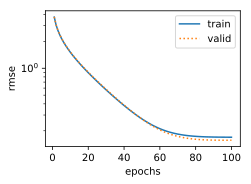

fold 0, train rmse: 0.169380, valid rmse: 0.156729


fold 1, train rmse: 0.162260, valid rmse: 0.189922


fold 2, train rmse: 0.163616, valid rmse: 0.167964


fold 3, train rmse: 0.167530, valid rmse: 0.154914


fold 4, train rmse: 0.162526, valid rmse: 0.182575
5-fold validation: avg train rmse: 0.165062, avg valid rmse: 0.170421


In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

어떤 하이퍼파라미터(hyperparameter) 세트들을 사용하면 학습 오류가 상당히 작게 나오나, $K$-겹 교차 검증($K$-fold cross-validation) 오류는 상당히 크게 나오는 현상을 발견하게 될 것 입니다. 이것은 대부분 오버피팅(overfitting)의 결과입니다. 따라서, 학습 오류를 줄일 때, $K$-겹 교차 검증($K$-fold cross-validation) 오류도 함께 감소하고 있는지를 확인하는 것이 필요합니다.

## 예측하고 제출하기

하이퍼파라미터(hyperparameter)의 좋은 조합을 찾았으면 (학습 데이터의 $1-1/k$  만큼 사용하는 것이 아니라) 모든 학습 데이터를 사용해서 모델을 학습시킵니다. 이렇게 학습된 모델을 테스트셋에 적용하고, 예측 결과를 CSV 파일에 저장해서 Kaggle에 업로드를 할 것입니다.

In [15]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

자 모델을 수행해 보겠습니다. 잘되고 있는지 확인하는 좋은 방법은 $K$-겹 교차 검증($K$-fold cross-validation)으로 예측한 것과 테스트셋에 대한 예측이 비슷하게 나오는지 확인해보는 것입니다. 만약 비슷하게 나온다면, 결과를 Kaggle에 업로드하세요.

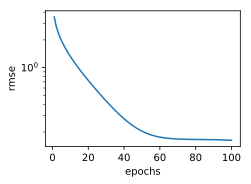

train rmse 0.162440


In [16]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

위 코드를 수행하면 `submission.csv` 파일이 생성됩니다. (CSV는 Kaggle에서 결과 파일로 받는 형식 중에 하나임) 그 다음, Kaggle에 예측 값을 제출해서 테스트 데이터셋에 대한 실제 집 가격과 비교해서 오류를 확인해보는 것입니다. 방법은 아주 간단합니다.

* Kaggle 웹사이트에 로그인하고, 집 값 예측 대회 페이지를 방문합니다.
* 오른 쪽의 "Submit Predictions" 또는 "Late Submission"을 클릭합니다.
* 점선 박스 안의 "Upload Submission File" 버튼을 클릭하고, 업로드할 예측 파일을 선택합니다.
* 페이지 아래에 있는 "Make Submission" 버튼을 클릭해서 여러분의 결과를 보세요.

![Submitting data to Kaggle](../img/kaggle_submit2.png)

## 요약

* 실제 데이터는 종종 다양한 데이터 타입의 값들을 갖고 있기 때문에, 전처리가 꼭 필요합니다.
* 실수 값을 평균이 0이고 분산이 1로 변환을 기본으로 선택하는 것은 좋은 방법이고, 누락된 값을 평균 값으로 채워 넣는 것도 그렇습니다.
* 카테고리 변수를 지표 변수(indicator variable)로 변환해서 이 값들을 벡터처럼 다룰 수 있습니다.
* 모델을 선택하고 하이퍼파라미터(hyper-parameter)를 선택하기 위해서 $K$-겹 교차 검증($K$-fold cross-validation)을 사용할 수 있습니다.
* 로그(Logarithm)는 상대적인 손실(loss)를 구하는데 유용합니다.

## 문제

1. 여러분이 수행한 예측 결과를 Kaggle에 제출하세요. 여러분의 예측이 얼마나 좋은가요?
1. log 가격을 직접 최소화하는 방법으로 모델을 향상시킬 수 있나요? 가격이 아닌 log 가격을 예측하도록 하면 어떻게 될까요?
1. 누락된 값을 평균값으로 채우는 방법이 항상 좋은 아이디어일까요? 힌트 - 값들이 불규칙하게 누락되지 않은 경우를 생각해보세요.
1. 누락된 값을 다루는 더 좋은 표현법을 찾아보세요. 힌트 - 지표 변수를 추가하면 어떻게 될까요?
1. $K$-겹 교차 검증($K$-fold cross-validation)을 이용해서 하이퍼파라미터(hyper-parameter)를 튜닝하고 더 Kaggle에서 좋은 점수를 획득해보세요.
1. 층 추가, 정규화 적용, 드롭아웃(dropout) 적용 등을 통해서 모델을 향상시켜서 점수를 높여보세요.
1. 연속된 수치 특성(feature) 이 절에서 한 것처럼 표준화하지 않은 경우 어떤일이 일어날까요?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2346)

![](../img/qr_kaggle-house-price.svg)